In [313]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [390]:
import numpy as np
from scipy.optimize import fmin
from shapely.geometry.polygon import LinearRing
from shapely.geometry import Polygon
from matplotlib import patches
from matplotlib import pyplot as pl

def ellipse_polyline(ellipses, n=100):
    # from http://stackoverflow.com/questions/18326900/finding-intersection-between-ellipse-and-a-line
    t = np.linspace(0, 2*np.pi, n, endpoint=False)
    st = np.sin(t)
    ct = np.cos(t)
    result = []
    for x0, y0, a, b, angle in ellipses:
        angle = np.deg2rad(angle)
        sa = np.sin(angle)
        ca = np.cos(angle)
        p = np.empty((n, 2))
        p[:, 0] = x0 + a * ca * ct - b * sa * st
        p[:, 1] = y0 + a * sa * ct + b * ca * st
        result.append(p)
    return result

def make_ellipse_polys(ellipses, n=100):
    return [Polygon(ellipse_polyline([ell], n)[0]) for ell in ellipses]

def areas(ellipses, n=100):
    pa, pb, pc = make_ellipse_polys(ellipses, n)
    # order: Abc, aBc, ABc, abC, AbC, aBC, ABC
    subregions = [pa - pb - pc,
                  pb - pa - pc,
                  (pa & pb) - pc,
                  pc - pa - pb,
                  (pa & pc) - pb,
                  (pb & pc) - pa,
                  pa & pb & pc]
    region_areas = np.array([r.area for r in subregions])
    norm_areas = region_areas / region_areas.sum()
    
    return norm_areas

def errfun(ellparams, true_areas, n=100):#, circ_lambda=1e-5):
    split_ellparams = np.split(np.array(ellparams), 3) # split up params for the three ellipses
    #circ_pen = np.sum([np.abs(np.log(el[2] / el[3])) for el in split_ellparams])
    #if np.isnan(circ_pen):
    #    circ_pen = 1000.
    sub_areas = areas(split_ellparams, n) # find areas of 7 regions
    err = np.sum((sub_areas - true_areas) ** 2)# + (circ_lambda * circ_pen)
    return err

def fit_venn3(true_areas):
    res = fmin(errfun, np.array([0, 0, 1, 1, 0, 
                                 0, 1, 1, 1, 0, 
                                 1, .5, 1, 1, 0]), 
               (true_areas,), disp=True, maxiter=1e5, xtol=1e-8)
    return np.split(res, 3)

def plot_venn3(ellparams, colors):
    a,b,c = make_ellipse_polys(ellparams)
    # order: Abc, aBc, ABc, abC, AbC, aBC, ABC
    regions = [a - b - c,
               b - a - c,
               (a & b) - c,
               c - a - b,
               (a & c) - b,
               (b & c) - a,
               a & b & c]
    fig = pl.figure(figsize=(8,8))
    ax = fig.gca()

    region_coords = [np.array(r.exterior.xy).T for r in regions]
    mpl_regions = [patches.Polygon(xy, 
                                   transform=ax.transData, 
                                   facecolor=color,
                                   edgecolor='white',
                                   linewidth=3) 
                   for (xy,color) in zip(region_coords, colors)]
    [ax.add_patch(p) for p in mpl_regions]

    minxy = np.vstack(region_coords).min()
    maxxy = np.vstack(region_coords).max()
    ax.axis([minxy, maxxy, minxy, maxxy])
    ax.set_axis_off()
    
    return fig

In [391]:
# order: Abc, aBc, ABc, abC, AbC, aBC, ABC
true_areas = np.array([5, 3, 1, 78, 0, 8, 3.0])
#true_areas = np.array([280., 149, 43, 441, 19, 229, 220])
#true_areas = np.array([5, 9, 2, 65, 1, 30, 8.0])
true_areas /= true_areas.sum()
print true_areas

[ 0.05102041  0.03061224  0.01020408  0.79591837  0.          0.08163265
  0.03061224]


In [392]:
opt_ells = fit_venn3(true_areas)

In [393]:
print areas(np.split(res, 3))
print true_areas

[ 0.05101106  0.03069315  0.0103003   0.79595599  0.          0.08153109
  0.03050841]
[ 0.05102041  0.03061224  0.01020408  0.79591837  0.          0.08163265
  0.03061224]


In [394]:
modelcolor = {'powerspeccounts':[0,138,255], 'powerspeccounts_ampsq':[0,138, 255],
                       'articulationcounts':[60,154,85], 'english1000': [232,29,37],
                       'green': [96,255,96], 'purple': [180,96,255], 'orange':[249, 142,21],
                       'dark_green':[46,139,87], 'light_green':[64,255,31],
                       'dark_purple':[148,0,211], 'light_purple':[238,130,238],
                       'allmodels': [255,255,255], 'light_teal':[67,184,187]}
colors = np.array([modelcolor['powerspeccounts_ampsq'],
                        modelcolor['articulationcounts'],
                        modelcolor['light_teal'], # pow_art
                        modelcolor['english1000'],
                        modelcolor['light_purple'], # pow_sem
                        modelcolor['orange'], # art_sem
                        modelcolor['allmodels']]) / 255.0

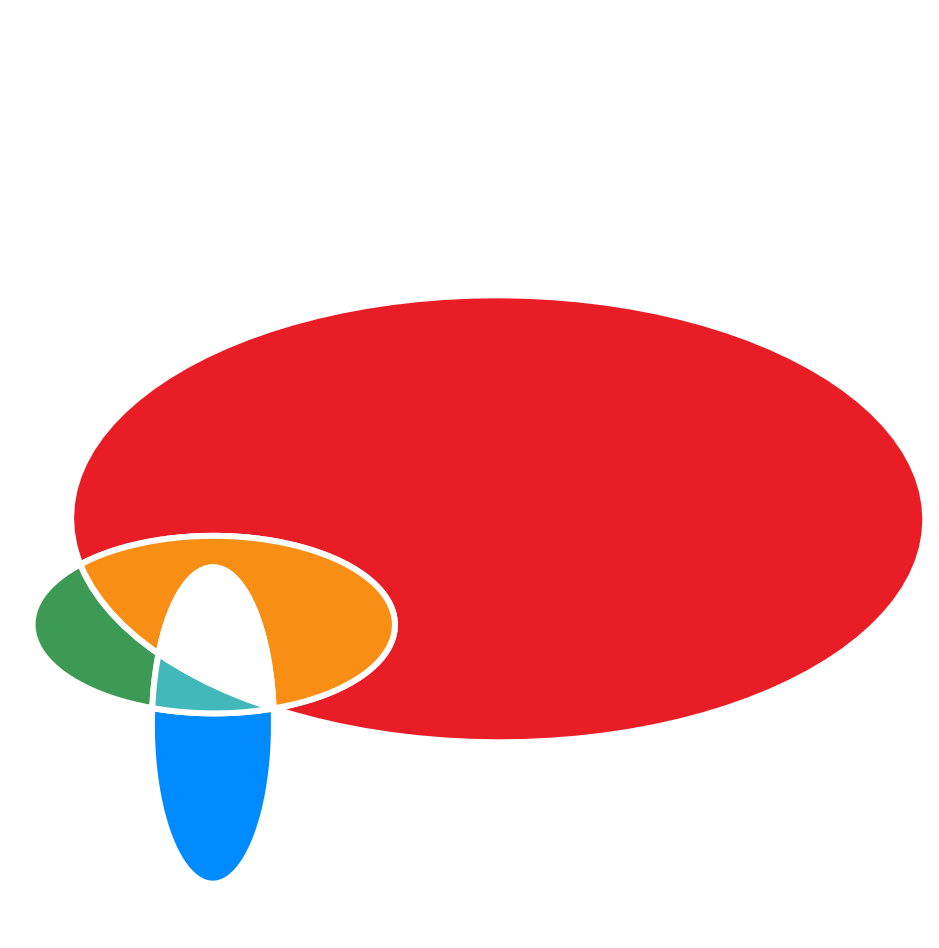

In [395]:
plot_venn3(opt_ells, colors);